In [1]:
import os
import h5py
from time import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from sklearn.decomposition import PCA

import pywt
import scipy
import imageio
import scipy.io as sio

from PIL import Image
from skimage.color import rgb2gray

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

from neuralop.models import FNO

my_box = dict(boxstyle='round', facecolor='lightgrey', edgecolor='k', alpha=0.5)

In [2]:
# fig = plt.figure(figsize=(15,5))
# ax = fig.add_subplot(111)

# frame = 0
# ax.imshow(df_sst[frame], cmap='gist_ncar')
# ax.set(xticks=[], yticks=[], title='t={}'.format(frame))
# plt.tight_layout()

# def update(frame):
#     ax.imshow(df_sst[frame], cmap='gist_ncar')
#     ax.set(xticks=[], yticks=[], title='t={}'.format(frame))
#     return ax

# ani = FuncAnimation(fig, update, frames=len(df_sst), interval=200, repeat=False)
# ani.save('animations/sst.gif', fps=20)

Permeability: (1272, 128, 128)


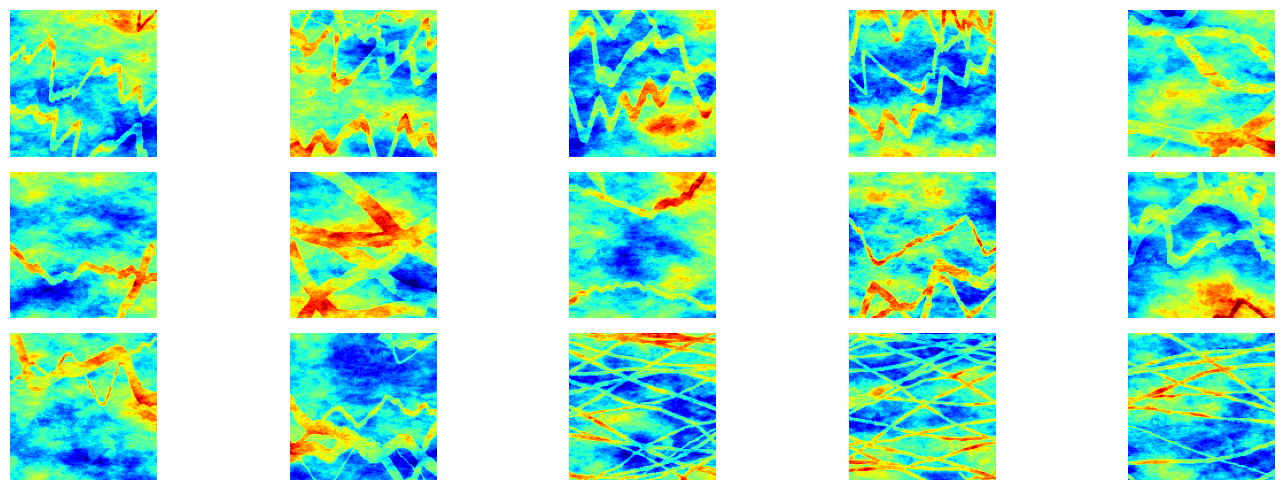

Channels: (500, 128, 128)


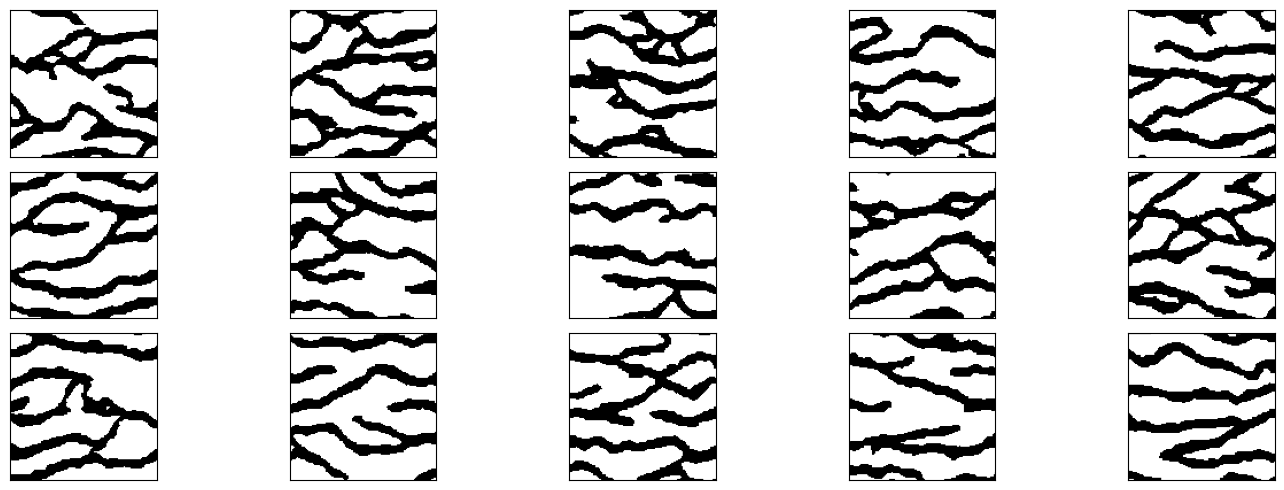

In [40]:
df_perm = np.rot90(np.load('data/data_1272_128x128.npz')['perm_norm'], k=1, axes=(1,2))
print('Permeability: {}'.format(df_perm.shape))
np.save('data/datasets/df_perm.npy', df_perm)

plt.figure(figsize=(15,5))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(df_perm[i], cmap='jet')
    plt.axis('off')
plt.tight_layout()
plt.show()

df_channels = np.moveaxis(np.load('data/MPS_Training_image_and_Realizations_500.npz')['array2'], -1, 0)
print('Channels: {}'.format(df_channels.shape))
np.save('data/datasets/df_channels.npy', df_channels)

plt.figure(figsize=(15,5))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(df_channels[i], cmap='binary')
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

FWI - Velocity: (30000, 70, 70) | Fault: (54000, 70, 70)


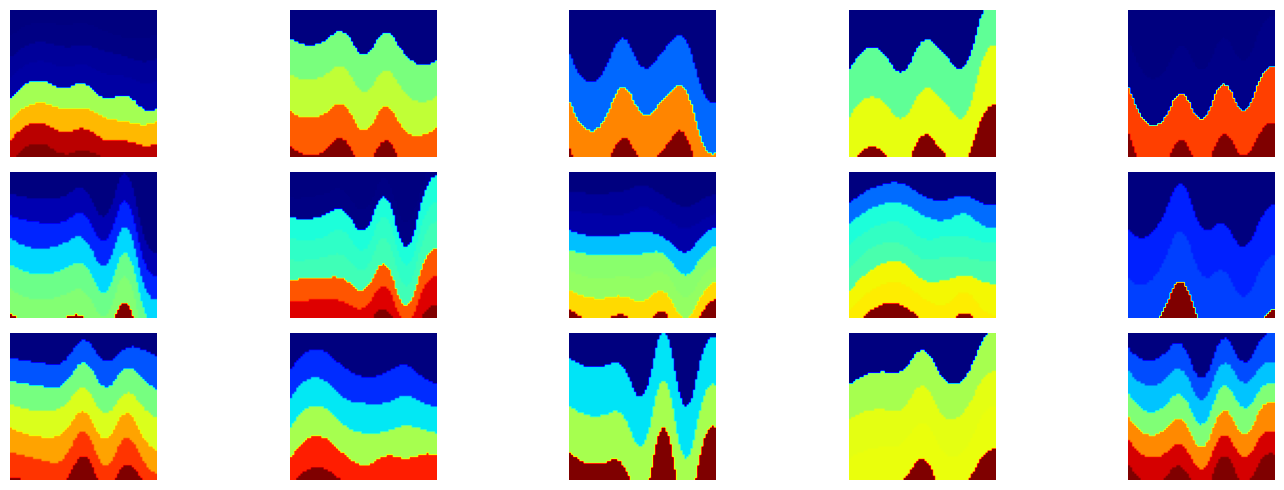

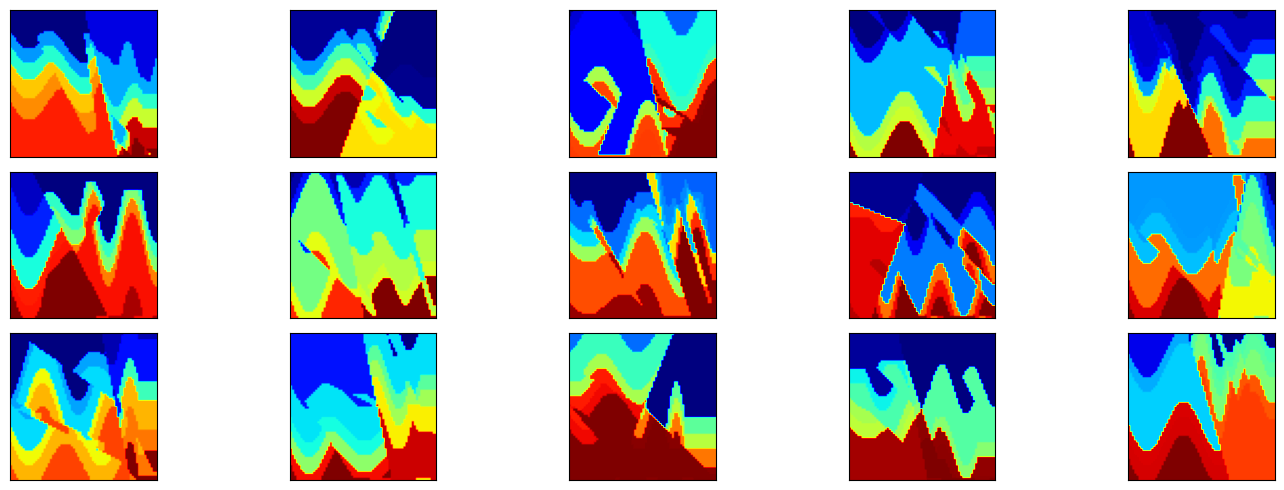

In [41]:
df_fwi_vel = np.load('data/datasets/df_fwi_vel.npy').squeeze()
df_fwi_fault = np.load('data/datasets/df_fwi_fault.npy').squeeze()
print('FWI - Velocity: {} | Fault: {}'.format(df_fwi_vel.shape, df_fwi_fault.shape))

plt.figure(figsize=(15,5))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(df_fwi_vel[i], cmap='jet')
    plt.axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,5))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(df_fwi_fault[i], cmap='jet')
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

Yale Faces: (2414, 32, 32)


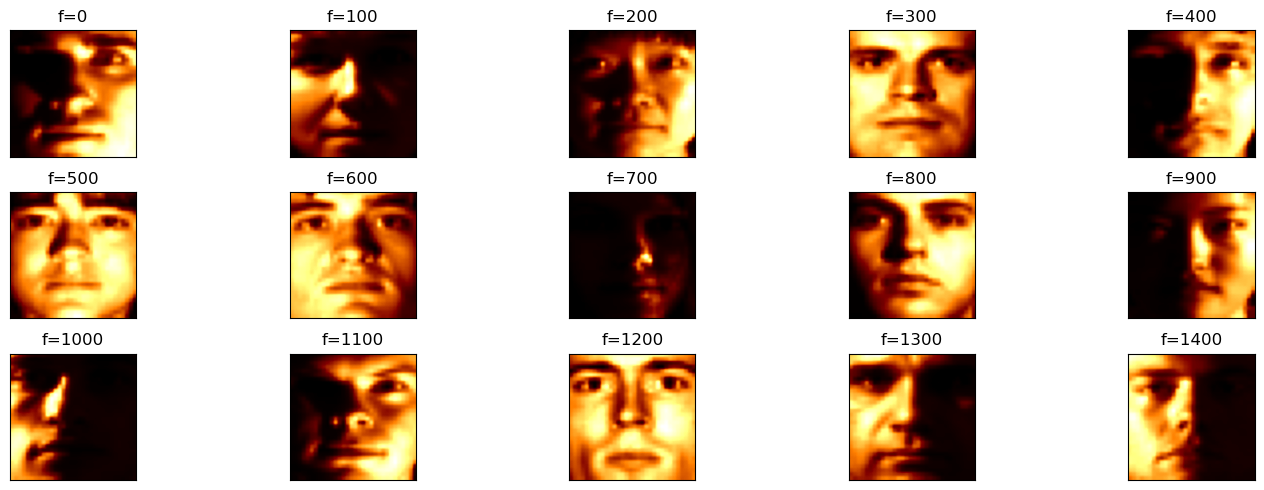

In [42]:
df_yale = np.load('data/datasets/df_yale.npy')
print('Yale Faces: {}'.format(df_yale.shape))

plt.figure(figsize=(15,5))
mult = 100
for i in range(15):
    plt.subplot(3,5,i+1)
    k = i*mult
    plt.imshow(df_yale[k], cmap='afmhot', interpolation='kaiser')
    plt.title('f={}'.format(k))
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

Flow Across Cylinder: (150, 199, 449)


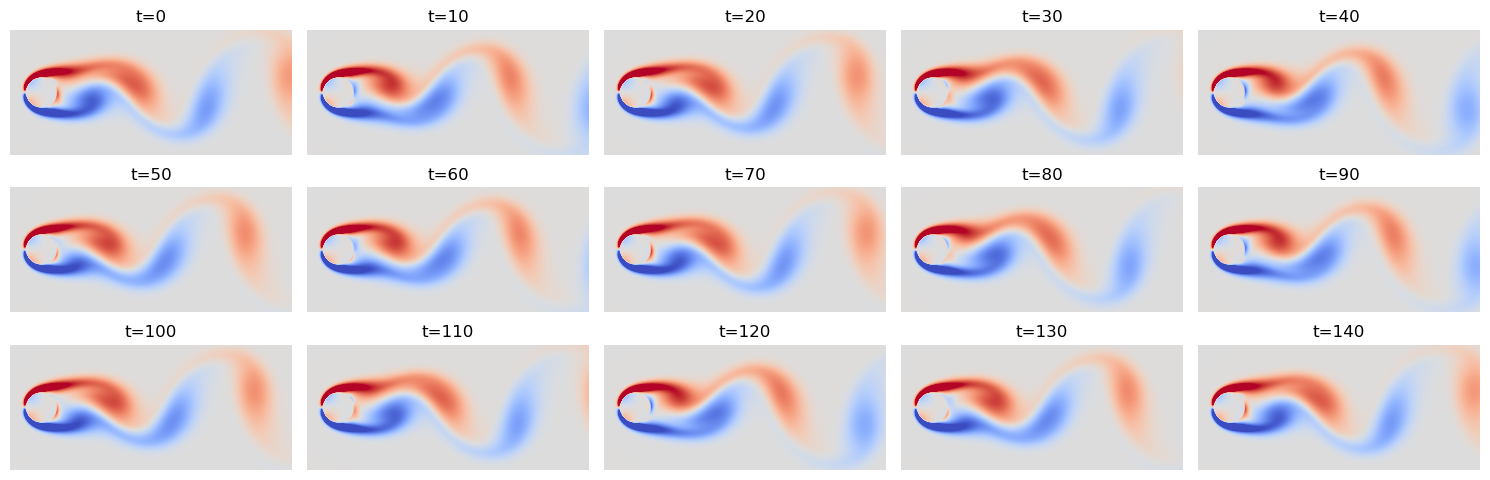

In [43]:
df_cylinder_t0 = np.load('data/datasets/df_cylinder_t0.npy')
print('Flow Across Cylinder: {}'.format(df_cylinder_t0.shape))

plt.figure(figsize=(15,5))
for i in range(15):
    k = i * 10
    plt.subplot(3,5,i+1)
    plt.imshow(df_cylinder_t0[k], cmap='coolwarm', vmin=-3, vmax=3, interpolation='gaussian')
    plt.title('t={}'.format(k))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
dx = np.zeros((100, 1, 199, 449))
dy = np.zeros((100, 10, 199, 449))
for i in range(100):
    dx[i] = np.expand_dims(df_cylinder_t0[i], 0)
    dy[i] = df_cylinder_t0[i+1:i+11]

print('x: {} | y: {}'.format(dx.shape, dy.shape))

X_train = torch.tensor(dx, dtype=torch.float32)
Y_train = torch.tensor(dy, dtype=torch.float32)
trainloader = DataLoader(TensorDataset(X_train, Y_train), batch_size=10, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FNO(num_layers=3, n_modes=(10,10),
            in_channels=1, lifting_channels=64, hidden_channels=64, projection_channels=64, out_channels=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 50
loss = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (x, y) in enumerate(trainloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        l = criterion(y_hat, y)
        l.backward()
        optimizer.step()
        running_loss += l.item()
    loss.append(running_loss)
    if epoch % 10 == 0:
        print('Epoch: {} | Loss: {:.4f}'.format(epoch, running_loss))

y_pred = model(X_train[:10].to(device)).detach().cpu().numpy()
print('Pred: {}'.format(y_pred.shape))

In [ ]:
sample = 9

fig, axs = plt.subplots(3, 10, figsize=(20,5), sharex=True, sharey=True)
for j in range(10):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    true = dy[sample,j]
    pred = y_pred[sample,j]
    diff = np.linalg.norm(np.expand_dims(true,-1) - np.expand_dims(pred,-1), axis=-1) / np.linalg.norm(true)

    im1 = ax1.imshow(dy[sample,j], cmap='coolwarm', vmin=-3, vmax=3, interpolation='gaussian')
    im2 = ax2.imshow(y_pred[sample,j], cmap='coolwarm', vmin=-3, vmax=3, interpolation='gaussian')
    im3 = ax3.imshow(diff, cmap='binary', vmin=0, vmax=0.0015)
plt.tight_layout()
plt.show()

In [ ]:
df_bz = np.load('data/datasets/df_bz.npy')
print('BZ: {}'.format(df_bz.shape))

plt.figure(figsize=(15,5))
mult = 85
for i in range(15):
    plt.subplot(3,5,i+1)
    k = i*mult
    plt.imshow(df_bz[k], cmap='cubehelix')
    plt.title('t={}'.format(k))
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
df_sst = np.load('data/datasets/df_sst.npy')
print('Sea Surface Temperature: {}'.format(df_sst.shape))

plt.figure(figsize=(15,5))
mult = 90
for i in range(15):
    plt.subplot(3,5,i+1)
    k = i*mult
    plt.imshow(df_sst[k], cmap='turbo')
    plt.title('t={}'.format(k))
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
dx = np.zeros((250, 1, 180, 360))
dy = np.zeros((250, 10, 180, 360))
for i in range(250):
    dx[i] = np.expand_dims(df_sst[i], 0)
    dy[i] = df_sst[i+1:i+11]

print('x: {} | y: {}'.format(dx.shape, dy.shape))

X_train = torch.tensor(dx, dtype=torch.float32)
Y_train = torch.tensor(dy, dtype=torch.float32)
trainloader = DataLoader(TensorDataset(X_train, Y_train), batch_size=10, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FNO(num_layers=3, n_modes=(10,10),
            in_channels=1, lifting_channels=64, hidden_channels=64, projection_channels=64, out_channels=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 50
loss = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (x, y) in enumerate(trainloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        l = criterion(y_hat, y)
        l.backward()
        optimizer.step()
        running_loss += l.item()
    loss.append(running_loss)
    if epoch % 10 == 0:
        print('Epoch: {} | Loss: {:.4f}'.format(epoch, running_loss))

y_pred = model(X_train[:10].to(device)).detach().cpu().numpy()
print('Pred: {}'.format(y_pred.shape))

In [ ]:
sample = 9

fig, axs = plt.subplots(3, 10, figsize=(20,5), sharex=True, sharey=True)
for j in range(10):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    true = dy[sample,j]
    pred = y_pred[sample,j]
    diff = np.linalg.norm(np.expand_dims(true,-1) - np.expand_dims(pred,-1), axis=-1) / np.linalg.norm(true)

    im1 = ax1.imshow(dy[sample,j], cmap='turbo')
    im2 = ax2.imshow(y_pred[sample,j], cmap='turbo')
    im3 = ax3.imshow(diff, cmap='binary')
plt.tight_layout()
plt.show()

Peru Land Satellite: (39, 377, 697, 3)


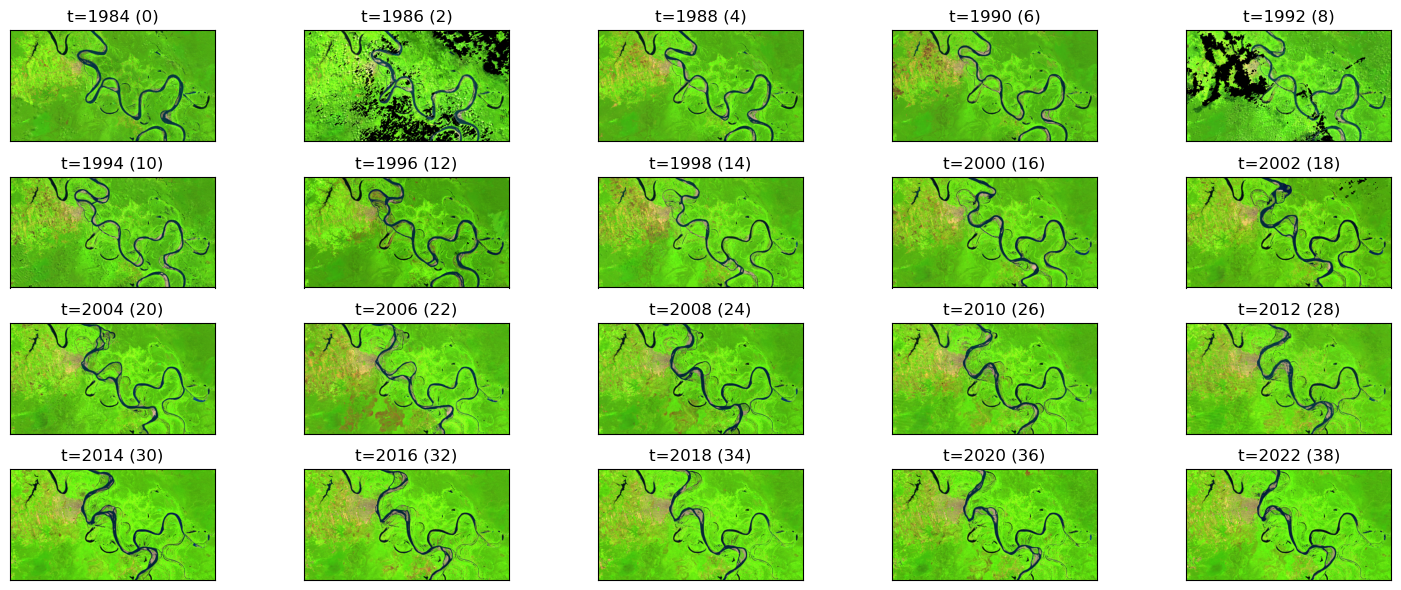

In [51]:
df_landsat = np.load('data/datasets/df_landsat.npy')
print('Peru Land Satellite: {}'.format(df_landsat.shape))

plt.figure(figsize=(15,6))
mult = 2
for i in range(20):
    plt.subplot(4,5,i+1)
    k = i*mult
    plt.imshow(df_landsat[k], cmap='turbo')
    plt.title('t={} ({})'.format(k+1984, k))
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
df_rd = np.load('data/datasets/df_rd.npy')
print('Reaction-Diffusion: {}'.format(df_rd.shape))

plt.figure(figsize=(15,5))
mult = 12
for i in range(15):
    plt.subplot(3,5,i+1)
    k = i*mult
    plt.imshow(df_rd[k], cmap='hot')
    plt.title('t={}'.format(k))
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
dx = np.zeros((150, 1, 512, 512))
dy = np.zeros((150, 10, 512, 512))
for i in range(150):
    dx[i] = np.expand_dims(df_rd[i], 0)
    dy[i] = df_rd[i+1:i+11]

print('x: {} | y: {}'.format(dx.shape, dy.shape))

X_train = torch.tensor(dx, dtype=torch.float32)
Y_train = torch.tensor(dy, dtype=torch.float32)
trainloader = DataLoader(TensorDataset(X_train, Y_train), batch_size=10, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FNO(num_layers=3, n_modes=(10,10),
            in_channels=1, lifting_channels=64, hidden_channels=64, projection_channels=64, out_channels=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs = 50
loss = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (x, y) in enumerate(trainloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        l = criterion(y_hat, y)
        l.backward()
        optimizer.step()
        running_loss += l.item()
    loss.append(running_loss)
    if epoch % 10 == 0:
        print('Epoch: {} | Loss: {:.3e}'.format(epoch, running_loss))

y_pred = model(X_train[:10].to(device)).detach().cpu().numpy()
print('Pred: {}'.format(y_pred.shape))

In [ ]:
sample = 9

fig, axs = plt.subplots(3, 10, figsize=(20,5), sharex=True, sharey=True)
for j in range(10):
    ax1, ax2, ax3 = axs[0,j], axs[1,j], axs[2,j]
    true = dy[sample,j]
    pred = y_pred[sample,j]
    diff = np.linalg.norm(np.expand_dims(true,-1) - np.expand_dims(pred,-1), axis=-1) / np.linalg.norm(true)

    im1 = ax1.imshow(dy[sample,j], cmap='viridis')
    im2 = ax2.imshow(y_pred[sample,j], cmap='viridis')
    im3 = ax3.imshow(diff, cmap='binary')
plt.tight_layout()
plt.show()

In [ ]:
df_mc = np.load('data/datasets/df_mc.npy')
print('Monte Carlo: {}'.format(df_mc.shape))

plt.figure(figsize=(15,5))
mult = 27
for i in range(15):
    plt.subplot(3,5,i+1)
    k = i*mult
    plt.imshow(df_mc[k])
    plt.title('t={}'.format(k))
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
df_ski = np.load('data/datasets/df_ski.npy')
print('Ski Drop: {}'.format(df_ski.shape))

plt.figure(figsize=(15,5))
mult = 27
for i in range(15):
    plt.subplot(3,5,i+1)
    k = i*mult
    plt.imshow(rgb2gray(df_ski[k]))
    plt.title('t={}'.format(k))
    plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

***
# END